In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# 코랩버전이 LMS버전과 맞지 않아 업데이트 해줘야함.
# !pip install statsmodels --upgrade
# 새 버전 설치 후 런타임 다시 시작해줘야함.

In [2]:
import pandas
import sklearn
import statsmodels
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.2


# 📢STEP 1 : 시계열 데이터 준비

::✔조건::

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
# 삼성 데이터 불러오기
# index_col 옵션으로 Date순으로 정렬,Prase_date옵션(default = False)으로 date column을 datetime 형식으로 df 생성.
csv_file_path ='/content/drive/MyDrive/Data/005930.KS.csv'
samsung_df = pd.read_csv(csv_file_path, index_col='Date', parse_dates=True)
# Close 항목을 보여주는 시계열 데이터 생성
ts_ss = samsung_df['Close']
ts_ss.head()

Date
2019-05-03    45300.0
2019-05-07    44850.0
2019-05-08    44250.0
2019-05-09    42450.0
2019-05-10    42900.0
Name: Close, dtype: float64

In [4]:
ts_ss.tail()

Date
2022-04-27    65000.0
2022-04-28    64800.0
2022-04-29    67400.0
2022-05-02    67300.0
2022-05-03    67500.0
Name: Close, dtype: float64

데이터는 삼성의 주가 데이터를 가져왔고, 19년 05월 03일 부터 22년 05월 03일 까지의 데이터를 기록한 데이터입니다.

In [5]:
type(ts_ss)

pandas.core.series.Series

ts_ss는 시리즈 타입 배열입니다.

# 📢STEP 2 : 각종 전처리 수행

## ✔결측치 처리

In [6]:
# 결측치 처리.
ts_ss[ts_ss.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

다행히 결측치는 없습니다.

Text(0, 0.5, 'price')

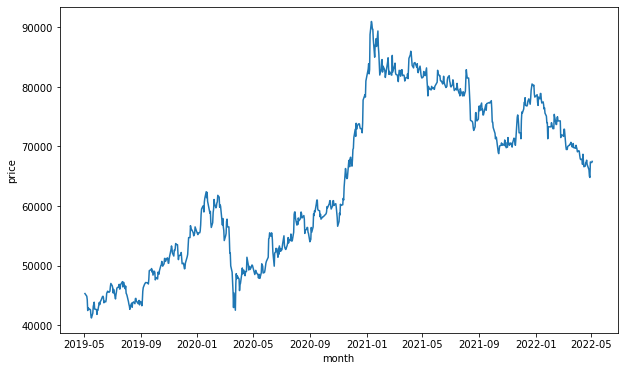

In [7]:
plt.figure(figsize=(10,6))
plt.plot(ts_ss)
plt.xlabel('month')
plt.ylabel('price')

## ✔로그 변환

Text(0, 0.5, 'price')

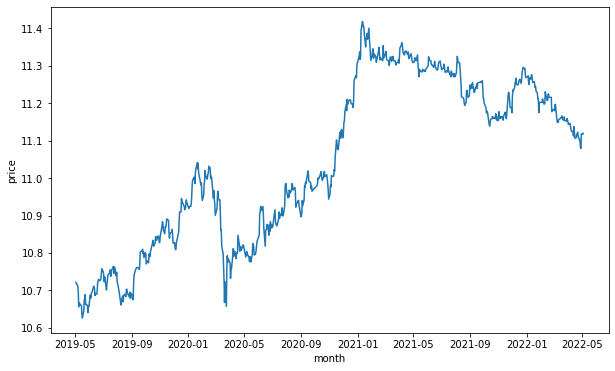

In [8]:
# 로그 변환
plt.figure(figsize=(10,6))
ts_ss_log = np.log(ts_ss)
plt.plot(ts_ss_log)
plt.xlabel('month')
plt.ylabel('price')

확실히 y 축의 scale이 줄어든 것을 확인할 수 있습니다.

# 📢STEP 3 : 시계열 안정성 분석



## ✔정성적 그래프 분석

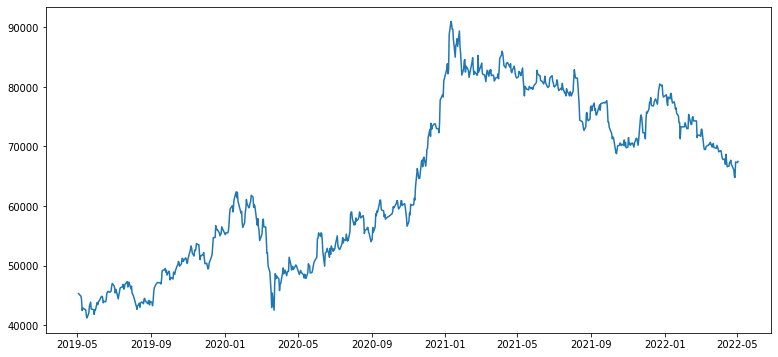

In [9]:
from matplotlib.pylab import rcParams
 # matlab 차트의 기본 크기를 13, 6으로 지정
rcParams['figure.figsize'] = 13, 6 

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts_ss)

In [10]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

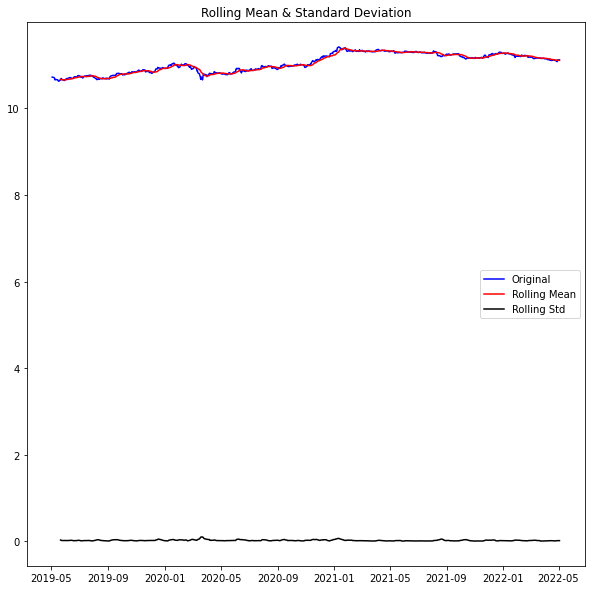

In [11]:
plt.figure(figsize=(10,10)) 
plot_rolling_statistics(ts_ss_log, window=12)

X 축의 scale이 너무 커서 정상성을 판단하기는 힘들것 같습니다.

## ✔정량적 Augmented Dicky-Fuller Test



In [12]:
from statsmodels.tsa.stattools import adfuller
#매개변수로 시계열 데이터 사용
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [13]:
augmented_dickey_fuller_test(ts_ss_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.516287
p-value                          0.525440
#Lags Used                       0.000000
Number of Observations Used    740.000000
Critical Value (1%)             -3.439218
Critical Value (5%)             -2.865454
Critical Value (10%)            -2.568854
dtype: float64


p-value의 값이 약0.53 이므로 귀무가설을 기각할 수 없다. 즉 stationary 한 시계열 데이터라 할 수 없습니다.

## ✔시계열 분해(Time Series Decomposition)

Stationary한 시계열 데이터라 할 수 없으므로 Stationary한 시계열로 가공해야 한다.

이미 log함수로 Scale을 변환한 상태에서 **Moving Avg를 제거**하거나, **Differencing(차분)**하여  Moving Avg제거로 상쇄되지 않는 주기적 변화를 제거해야 한다.

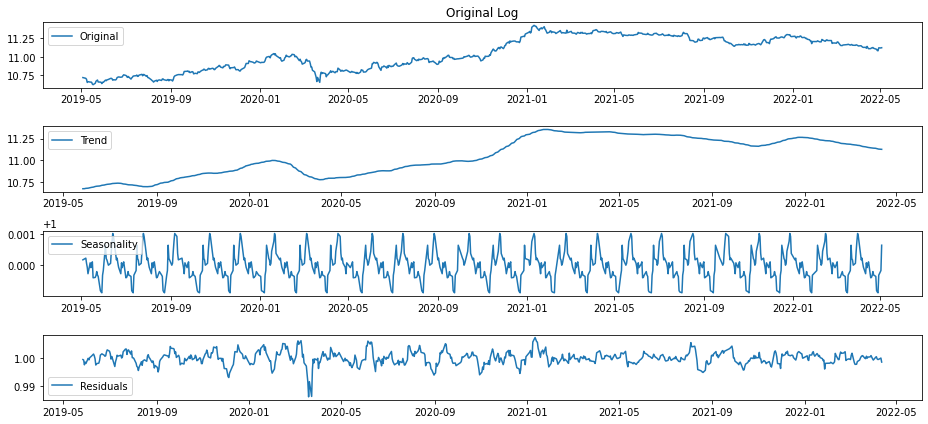

In [14]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose (ts_ss_log, model = 'multiplicative', period = 30) 

trend = decomposition.trend # 추세(Moving average) 추출 (시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성 추출 (패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) 에서 (추세 + 계절성) 제거한 데이터.

plt.rcParams["figure.figsize"] = (13,6)

plt.subplot(411)
plt.plot(ts_ss_log, label='Original')
plt.title('Original Log')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## ✔Residual 안정성 확인

In [15]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.466440e+00
p-value                        4.217721e-16
#Lags Used                     1.000000e+01
Number of Observations Used    7.000000e+02
Critical Value (1%)           -3.439726e+00
Critical Value (5%)           -2.865678e+00
Critical Value (10%)          -2.568973e+00
dtype: float64


p-value 의 값이 매우매우매우X100000 낮아진 것을 확인 할 수 있다.

따라서 **'귀무가설을 기각할 수 있다'**고 할 수있다.

# 📢STEP 4 : 학습, 테스트 데이터셋 생성


## ✔학습, 테스트 데이터셋 분리

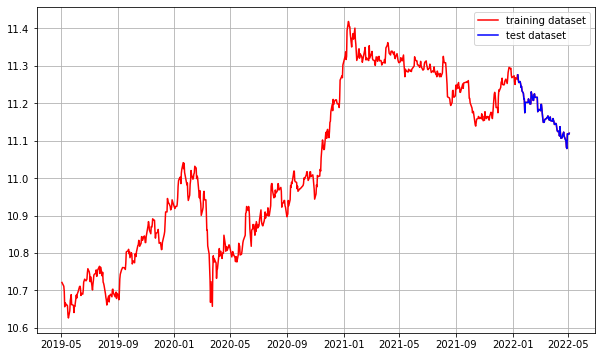

In [16]:
train_data, test_data = ts_ss_log[:int(len(ts_ss_log)*0.9)], ts_ss_log[int(len(ts_ss_log)*0.9):]
# [[YOUR CODE]]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_ss_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# 📢STEP 5 : 적정 ARIMA 모수 찾기

## ✔ACF, PACF 그려보기 -> p,q 구하기


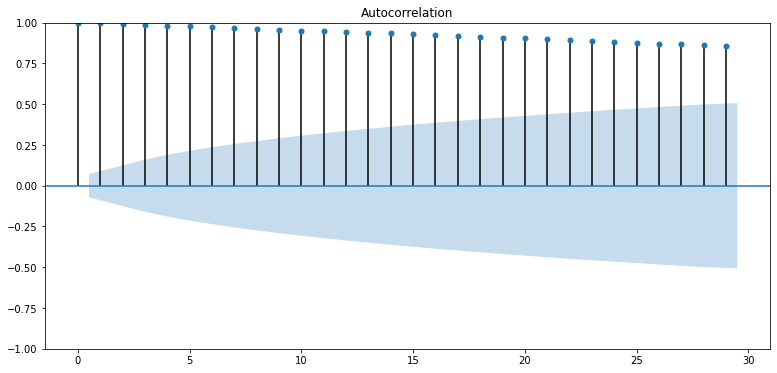

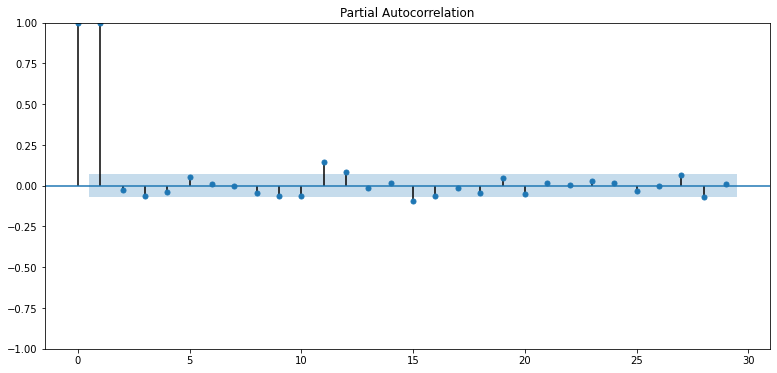

In [17]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_ss_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_ss_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

https://aliencoder.tistory.com/9

링크에 따르면

ACF 그래프에서는 서서히 감소하는 형태의 그래프가 그려졌으며 절단점이 발생하지 않았다. p = 0

PACF 그래프에서는 일정 p 이후 0에 가깝게 수렴하는 그래프가 그려졌다. 따라서 절단점이 2(=lag) 이다. 

결론적으로 로그 스케일링한 데이터 자체는 비정상성을 띄고 있으며 MA(1)모델을 사용해야 할 것 같다.

## ✔차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                 -26.832130
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    739.000000
Critical Value (1%)             -3.439230
Critical Value (5%)             -2.865459
Critical Value (10%)            -2.568857
dtype: float64


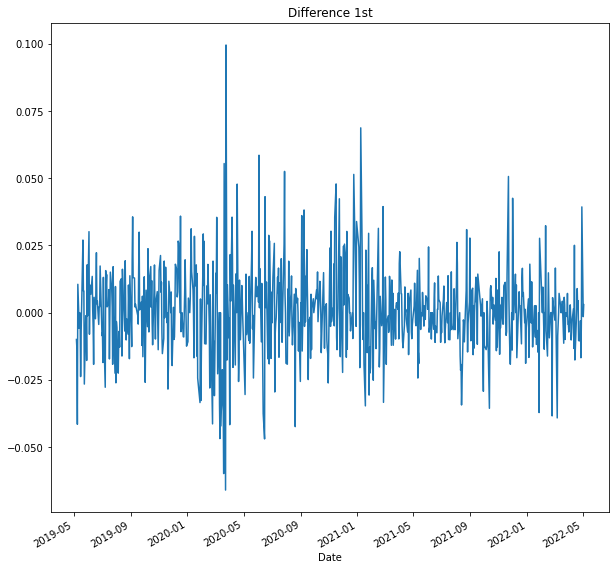

In [18]:
# 차분 안정성 확인 -> d 구하기
plt.figure(figsize=(10,10))
diff_1 = ts_ss_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.135011e+01
p-value                        1.004388e-20
#Lags Used                     1.800000e+01
Number of Observations Used    7.200000e+02
Critical Value (1%)           -3.439465e+00
Critical Value (5%)           -2.865563e+00
Critical Value (10%)          -2.568912e+00
dtype: float64


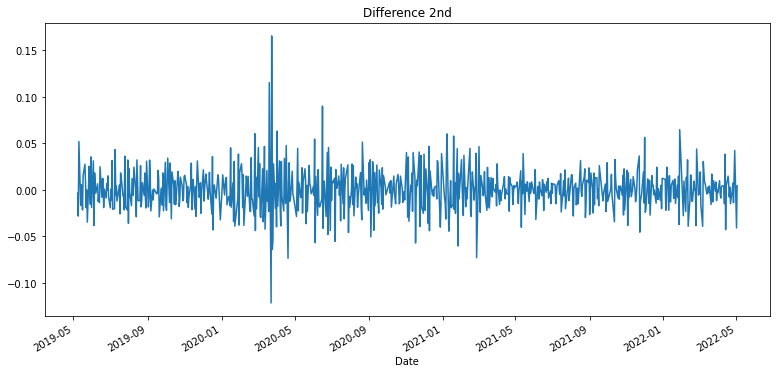

In [19]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분한 결과를 ACF, PACF함수로 출력하였다.

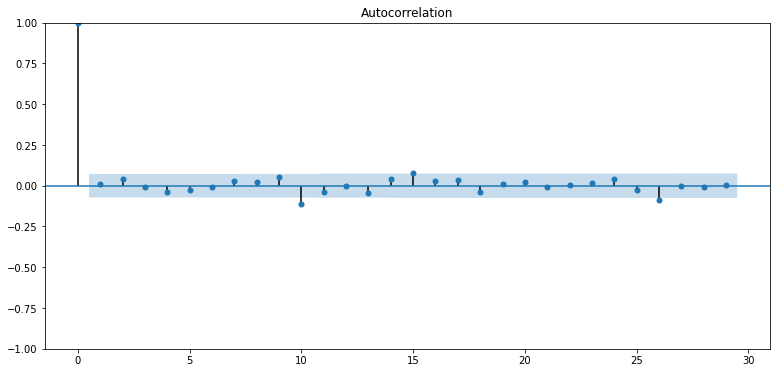

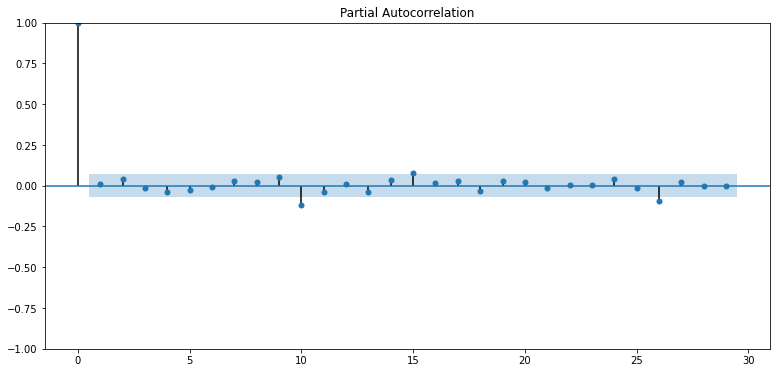

In [20]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 결과 Stationary한 Timeseries임을 알 수 있다.

마찬가지로 2차 차분한 결과를 ACF,PCAF 그래프로 그려보았다.

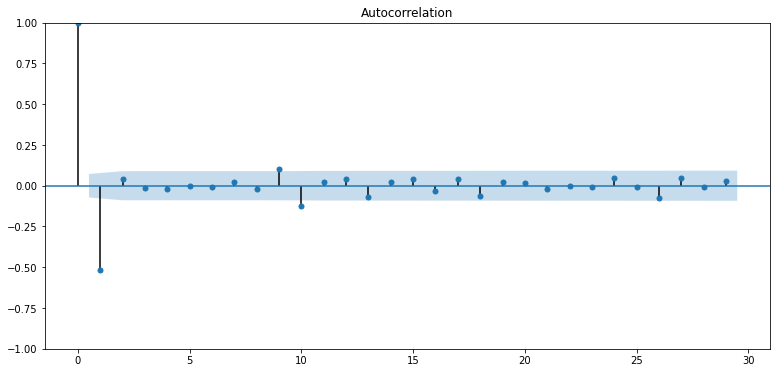

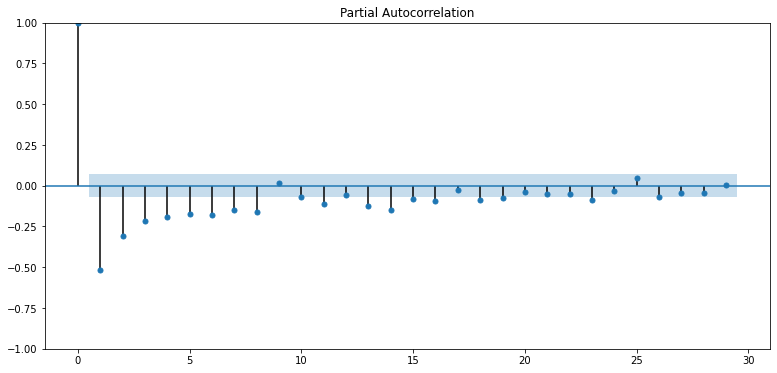

In [21]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

2차 차분시 1차 차분보다 안정적이지는 않은것 같다.

따라서 1차 차분한 결과가 가장 안정적이므로 b값은 1이 타당하다.

# 📢STEP 6 : ARIMA 모델 훈련과 테스트

## ✔ARIMA 모델 빌드와 훈련

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
# train 데이터 셋과 p,b,q =(0 1 1)인 ARIMA모델을 model에 할당.
model = ARIMA(train_data, order=(0, 1, 1))  
# Training된 모델을 fited_m에 할당.
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  666
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1775.864
Date:                Thu, 05 May 2022   AIC                          -3547.728
Time:                        13:02:58   BIC                          -3538.728
Sample:                             0   HQIC                         -3544.241
                                - 666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0174      0.025      0.699      0.484      -0.031       0.066
sigma2         0.0003   1.01e-05     27.762      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [23]:
type(fitted_m.summary())

statsmodels.iolib.summary.Summary

## ✔모델 테스트 및 플로팅


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


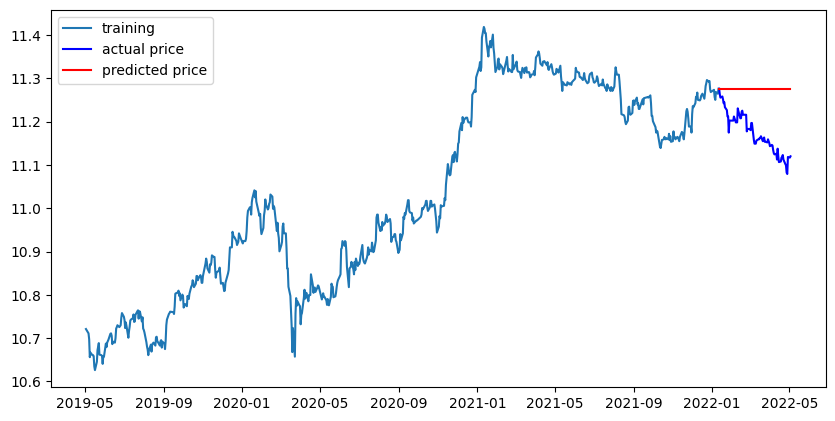

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
# 테스트 데이터만큼의 길이를 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

## ✔최종 예측 모델 정확도 측정(MAPE)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  71036236.64155754
MAE:  7725.14015531986
RMSE:  8428.299747965633
MAPE: 11.10%


# 📢STEP 7 : 다른 주식 종목 예측해 보기

관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## ✔종목1 - 카카오

In [26]:
# 데이터 불러오기
# index_col 옵션으로 Date순으로 정렬,Prase_date옵션(default = False)으로 date column을 datetime 형식으로 df 생성.
csv_file_path2 ='/content/drive/MyDrive/Data/035720.KS.csv'
_df = pd.read_csv(csv_file_path2, index_col='Date', parse_dates=True)
# Close 항목을 보여주는 시계열 데이터 생성
ts_kko = _df['Close']
ts_kko .head()
# 결측치 처리.
ts_kko [ts_kko .isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치는 없는것을 확인했습니다.

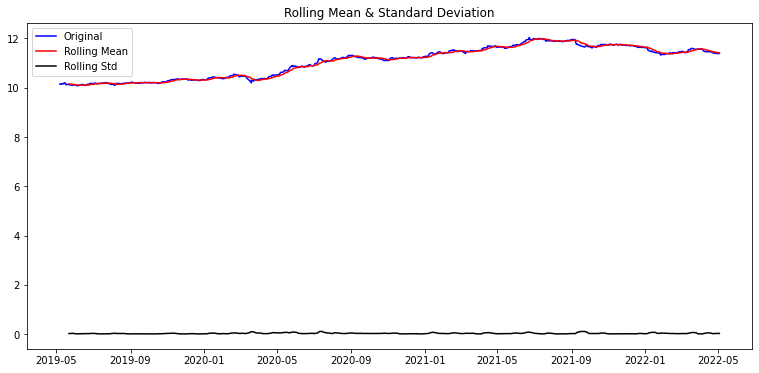

In [27]:
# 로그 변환
ts_log_kko = np.log(ts_kko)

plot_rolling_statistics(ts_log_kko, window=12)

Results of Dickey-Fuller Test:
Test Statistic                  -1.375006
p-value                          0.594198
#Lags Used                       3.000000
Number of Observations Used    737.000000
Critical Value (1%)             -3.439254
Critical Value (5%)             -2.865470
Critical Value (10%)            -2.568863
dtype: float64


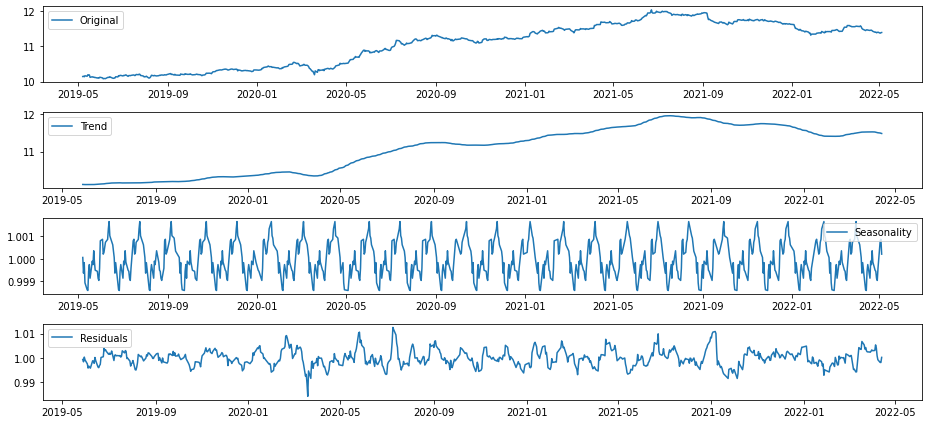

In [28]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_kko)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_kko, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_kko, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.196148e+00
p-value                        2.060182e-15
#Lags Used                     3.000000e+00
Number of Observations Used    7.070000e+02
Critical Value (1%)           -3.439633e+00
Critical Value (5%)           -2.865637e+00
Critical Value (10%)          -2.568952e+00
dtype: float64


귀무가설을 기각할 만한 p-value 값입니다.

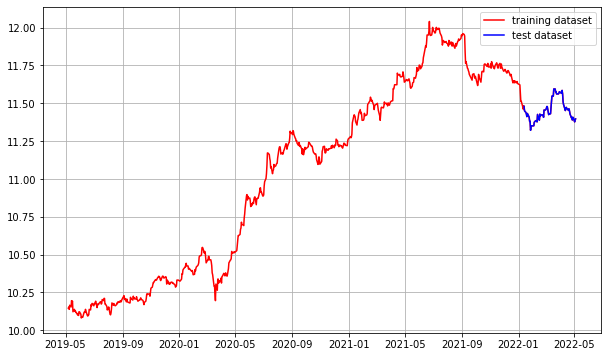

In [30]:
#학습, 테스트 데이터셋 분리
train_data, test_data = ts_log_kko[:int(len(ts_log_kko)*0.9)], ts_log_kko[int(len(ts_log_kko)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_kko, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

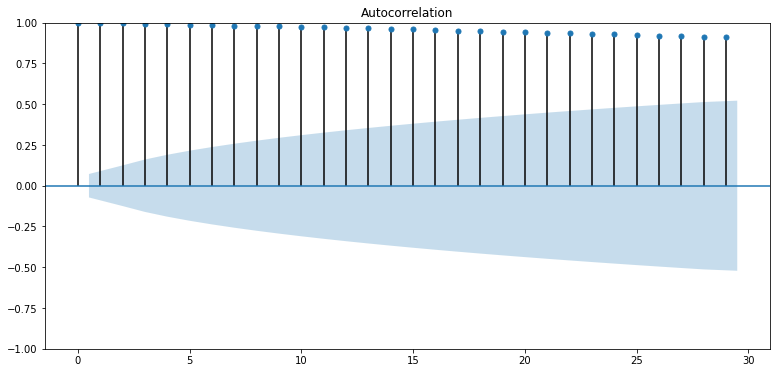

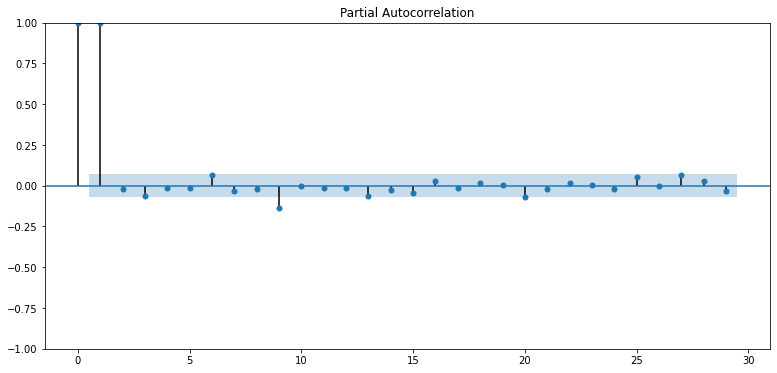

In [31]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_kko)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_kko)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF 와 PACF그래프를 그린 결과 비정상성을 띄고 있고, PACF그래프에서 절단점이 2에서 나타나므로 MA(1)모델을 사용하려 합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.401037e+01
p-value                        3.723101e-26
#Lags Used                     2.000000e+00
Number of Observations Used    7.370000e+02
Critical Value (1%)           -3.439254e+00
Critical Value (5%)           -2.865470e+00
Critical Value (10%)          -2.568863e+00
dtype: float64


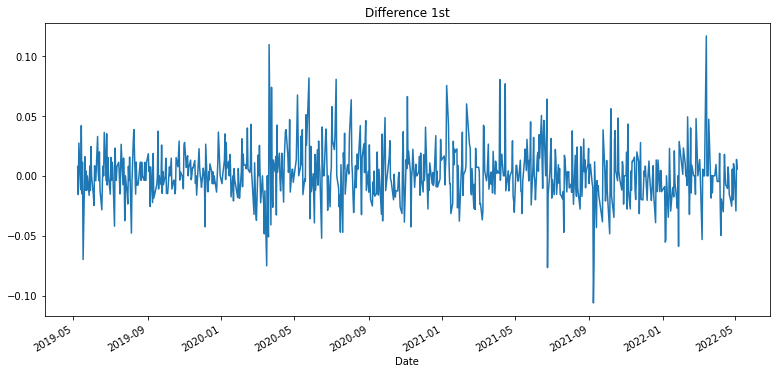

In [32]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log_kko.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.179012e+01
p-value                        9.872016e-22
#Lags Used                     1.400000e+01
Number of Observations Used    7.240000e+02
Critical Value (1%)           -3.439414e+00
Critical Value (5%)           -2.865540e+00
Critical Value (10%)          -2.568900e+00
dtype: float64


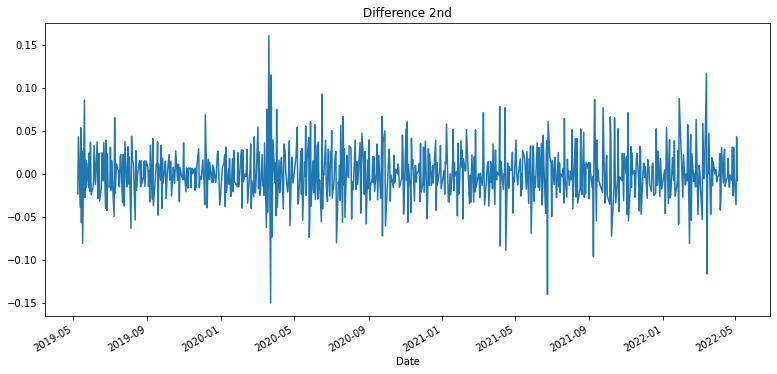

In [33]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분에서 p-value가 더 낮으므로(정상성이 더 높으므로 b=1) 을 채택하겠습니다.

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model

model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  666
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1565.211
Date:                Thu, 05 May 2022   AIC                          -3126.422
Time:                        13:03:05   BIC                          -3117.423
Sample:                             0   HQIC                         -3122.935
                                - 666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0599      0.030      1.987      0.047       0.001       0.119
sigma2         0.0005   1.95e-05     27.121      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


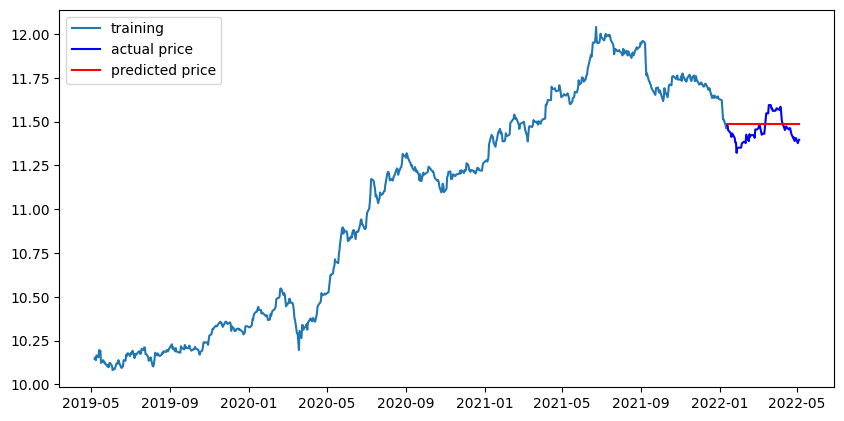

In [35]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  52274682.51924218
MAE:  6517.974445193025
RMSE:  7230.1232713725
MAPE: 6.94%


## ✔종목2 - Apple

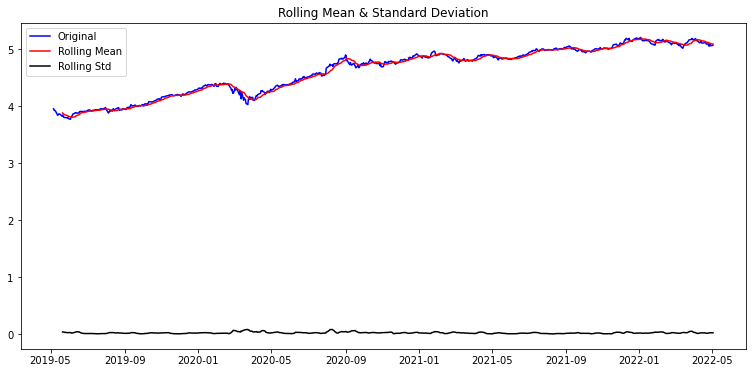

Results of Dickey-Fuller Test:
Test Statistic                  -1.589639
p-value                          0.488796
#Lags Used                       9.000000
Number of Observations Used    746.000000
Critical Value (1%)             -3.439146
Critical Value (5%)             -2.865422
Critical Value (10%)            -2.568837
dtype: float64


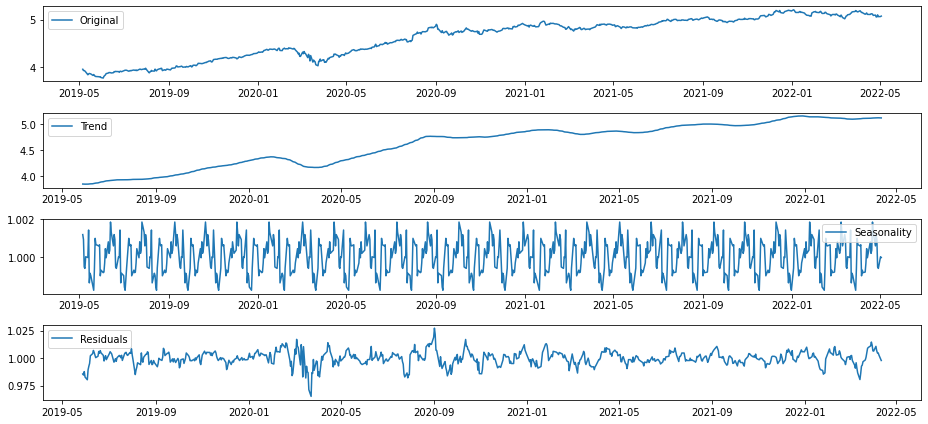

In [37]:
# 데이터 불러오기
# index_col 옵션으로 Date순으로 정렬,Prase_date옵션(default = False)으로 date column을 datetime 형식으로 df 생성.
csv_file_path3 ='/content/drive/MyDrive/Data/AAPL.csv'
_df = pd.read_csv(csv_file_path3, index_col='Date', parse_dates=True)
# Close 항목을 보여주는 시계열 데이터 생성
ts_ap = _df['Close']
ts_ap.head()
# 결측치 처리.
ts_ap[ts_ap.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log_ap = np.log(ts_ap)
# 정성적 그래프 분석

plot_rolling_statistics(ts_log_ap, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_ap)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_ap, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_ap, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [38]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.690783e+00
p-value                        1.421166e-11
#Lags Used                     1.900000e+01
Number of Observations Used    7.060000e+02
Critical Value (1%)           -3.439646e+00
Critical Value (5%)           -2.865643e+00
Critical Value (10%)          -2.568955e+00
dtype: float64


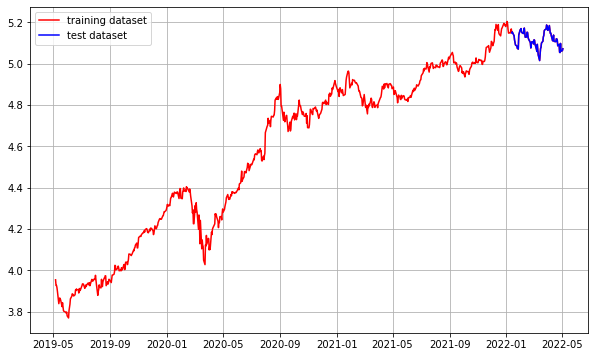

In [39]:
#학습, 테스트 데이터셋 분리
train_data, test_data = ts_log_ap[:int(len(ts_log_ap)*0.9)], ts_log_ap[int(len(ts_log_ap)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_ap, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

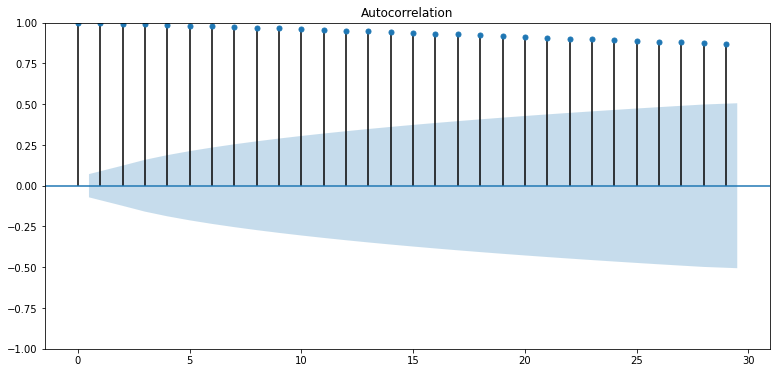

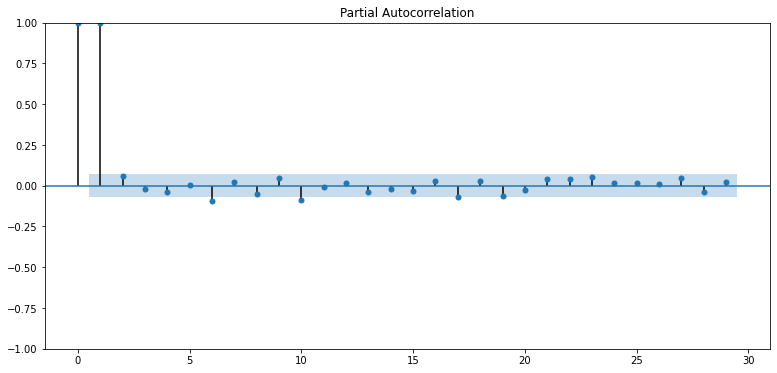

In [40]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_ap)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_ap)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

삼성, 카카오와 마찬가지 이유로 MA(1) 모델을 사용하겠습니다.

**q=1**

Results of Dickey-Fuller Test:
Test Statistic                -8.736348e+00
p-value                        3.092844e-14
#Lags Used                     8.000000e+00
Number of Observations Used    7.460000e+02
Critical Value (1%)           -3.439146e+00
Critical Value (5%)           -2.865422e+00
Critical Value (10%)          -2.568837e+00
dtype: float64


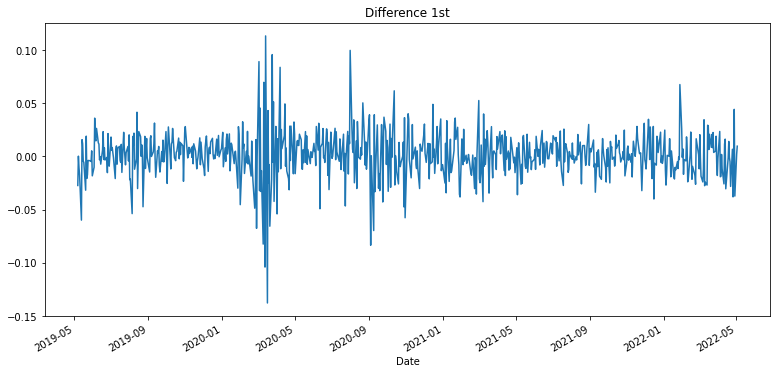

In [41]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log_ap.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.152780e+01
p-value                        3.897617e-21
#Lags Used                     1.700000e+01
Number of Observations Used    7.360000e+02
Critical Value (1%)           -3.439266e+00
Critical Value (5%)           -2.865475e+00
Critical Value (10%)          -2.568865e+00
dtype: float64


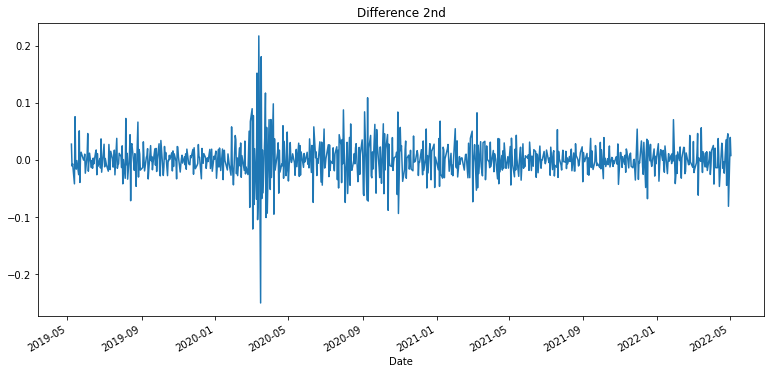

In [42]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분한 결과의 p-vlaue가 더 낮으므로  **b=2**를 선택하겠습니다.

In [43]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
# p,b,q = 0 2 1인 아리마 모델 생성
model = ARIMA(train_data, order=(0, 2, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  680
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1629.341
Date:                Thu, 05 May 2022   AIC                          -3254.682
Time:                        13:03:14   BIC                          -3245.644
Sample:                             0   HQIC                         -3251.183
                                - 680                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.815     -1.227      0.220      -2.598       0.598
sigma2         0.0005      0.000      1.226      0.220      -0.000       0.001
Ljung-Box (L1) (Q):                  23.32   Jarque-

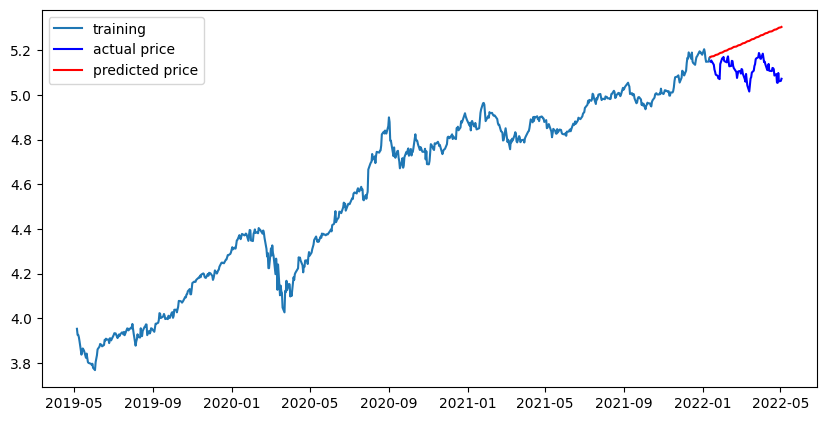

In [44]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  569.2710649539022
MAE:  21.390870200260586
RMSE:  23.8594020242315
MAPE: 13.02%


## ✔종목3  LVMH

In [46]:
# 데이터 불러오기
# index_col 옵션으로 Date순으로 정렬,Prase_date옵션(default = False)으로 date column을 datetime 형식으로 df 생성.
csv_file_path4 ='/content/drive/MyDrive/Data/MC.PA.csv'
LV_df = pd.read_csv(csv_file_path4, index_col='Date', parse_dates=True)
# Close 항목을 보여주는 시계열 데이터 생성
ts_LV = LV_df['Close']
ts_LV.head()
# 결측치 처리.
ts_LV[ts_LV.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
ts_log_LV = np.log(ts_LV)

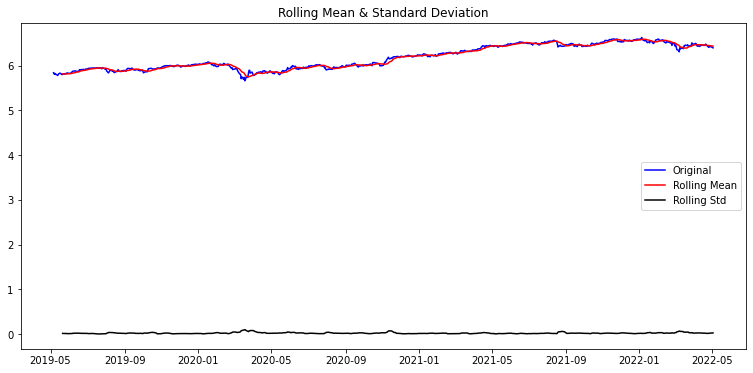

Results of Dickey-Fuller Test:
Test Statistic                  -1.216361
p-value                          0.666518
#Lags Used                      14.000000
Number of Observations Used    756.000000
Critical Value (1%)             -3.439029
Critical Value (5%)             -2.865371
Critical Value (10%)            -2.568810
dtype: float64


In [47]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log_LV, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_LV)

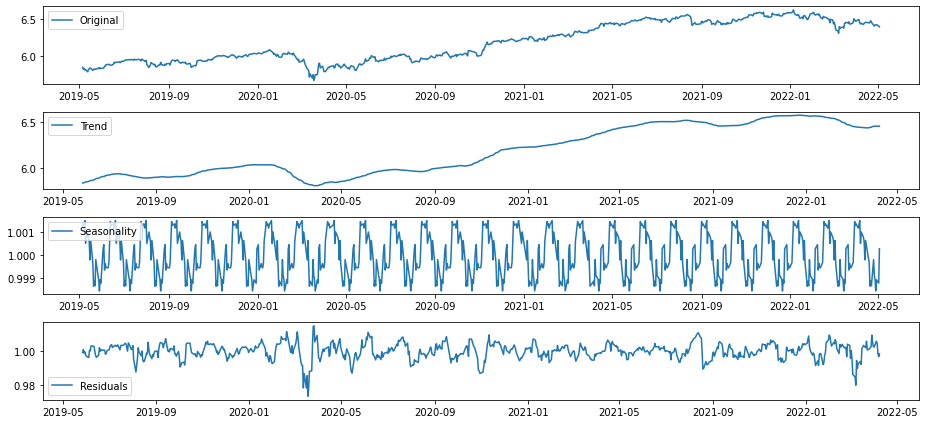

In [48]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_LV, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_LV, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [49]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.090151e+00
p-value                        3.843790e-15
#Lags Used                     1.700000e+01
Number of Observations Used    7.230000e+02
Critical Value (1%)           -3.439427e+00
Critical Value (5%)           -2.865546e+00
Critical Value (10%)          -2.568903e+00
dtype: float64


귀무가설을 기각할 만한 p-value입니다.

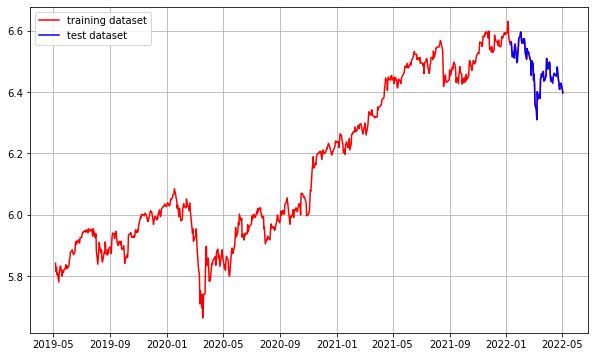

In [50]:
#학습, 테스트 데이터셋 분리
train_data, test_data = ts_log_LV[:int(len(ts_log_LV)*0.9)], ts_log_LV[int(len(ts_log_LV)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_LV, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log_LV를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

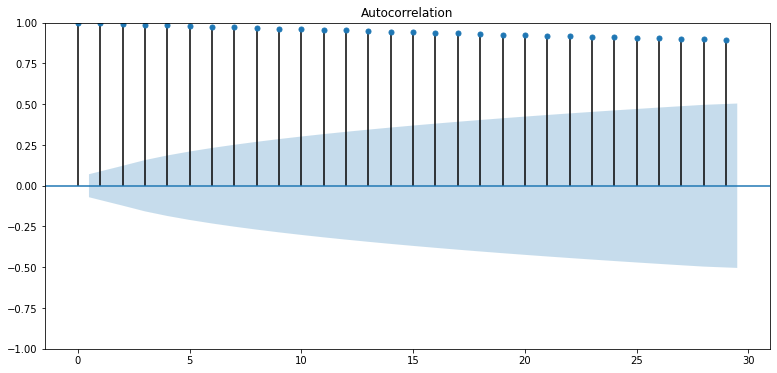

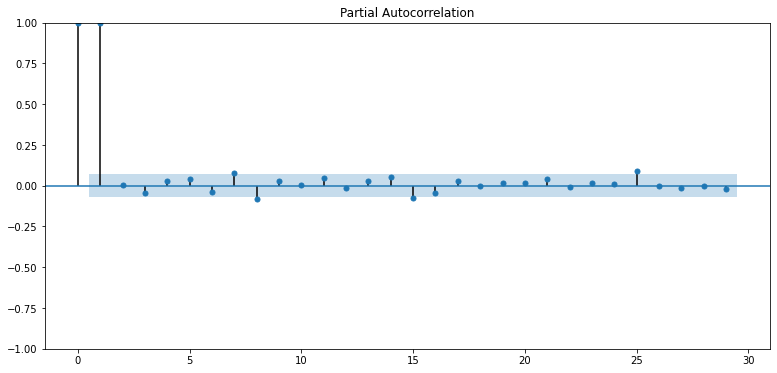

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_LV)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_LV)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위 세개와 마찬가지 이유로 MA(1)모델을 사용하겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -7.731032e+00
p-value                        1.125280e-11
#Lags Used                     1.300000e+01
Number of Observations Used    7.560000e+02
Critical Value (1%)           -3.439029e+00
Critical Value (5%)           -2.865371e+00
Critical Value (10%)          -2.568810e+00
dtype: float64


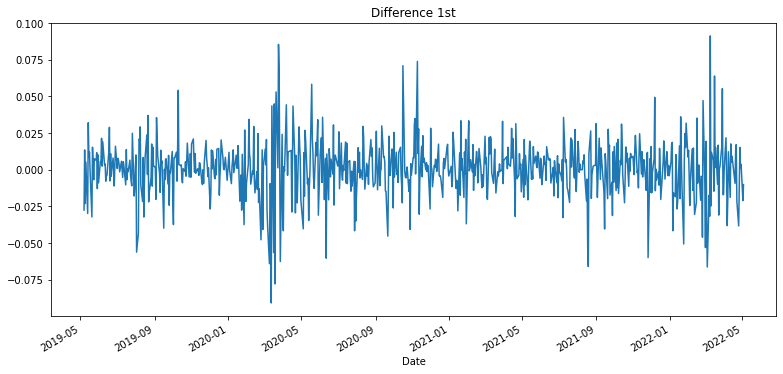

In [52]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log_LV.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.403616e+01
p-value                        3.366501e-26
#Lags Used                     1.300000e+01
Number of Observations Used    7.550000e+02
Critical Value (1%)           -3.439041e+00
Critical Value (5%)           -2.865376e+00
Critical Value (10%)          -2.568813e+00
dtype: float64


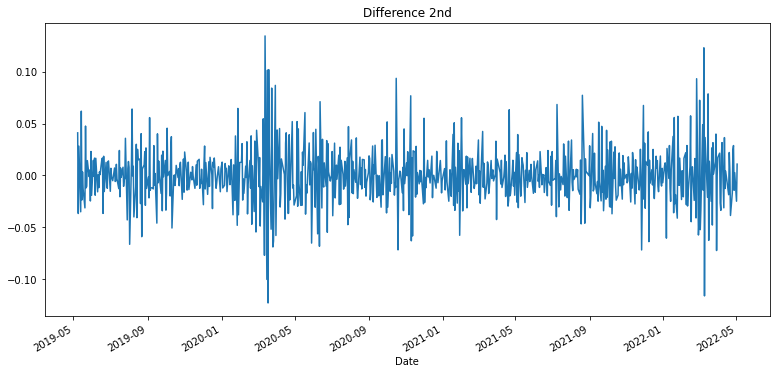

In [53]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

차분시 2차 차분의 p-value값이 더 낮으므로 **b = 2** 를 사용하겠습니다.

In [54]:
model = ARIMA(train_data, order=(0, 2, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  693
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1777.543
Date:                Thu, 05 May 2022   AIC                          -3551.086
Time:                        13:03:23   BIC                          -3542.010
Sample:                             0   HQIC                         -3547.575
                                - 693                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.837     -1.195      0.232      -2.640       0.640
sigma2         0.0003      0.000      1.196      0.232      -0.000       0.001
Ljung-Box (L1) (Q):                   1.13   Jarque-

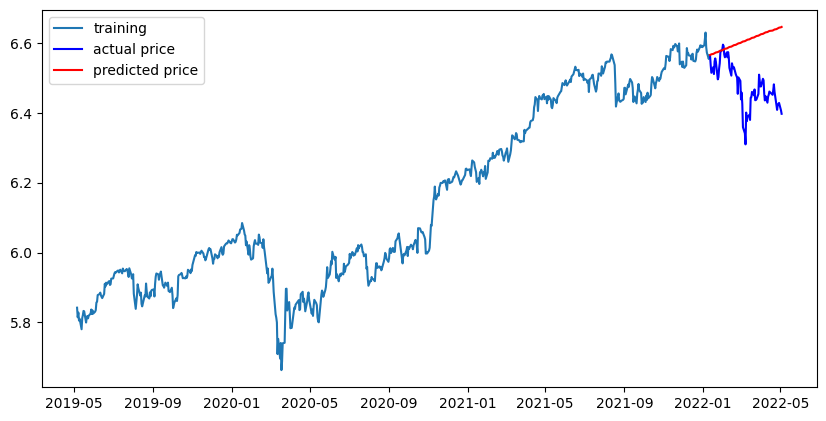

In [55]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10477.427711820237
MAE:  87.55922371509348
RMSE:  102.3593069135398
MAPE: 13.95%


# 📢마치며

ARIMA 모델을 이용한 시계열 예측은 통계적 배경지식 없이 이해하기 힘든 프로젝트 였습니다... 흑흑

이론은 아직도 잘 이해가 안되지만. 그래도 ARIMA 모델을 어떻게 사용하는지, 모수는 어떻게 결정해야 하는지 등은 확실히 이해가 되어서 다행이라 생각합니다.

다만 이번에 사용한 주식 데이터들은 대부분 ACF,PACF, Differecing을 거쳐 p,b,q 를 결정했음에도 불구하고 높은 정확도는 기대하기 힘들었습니다.

오히려 모수를 아무렇게나 설정했을 때 정확도가 더 높은 경우도 보았기 때문에 '다른 모델이나 더 많은 변수를 사용해야 정확도를 높일 수 있지 않을까?' 하는 직관적인 추측만 남긴 채 끝이 났습니다.

그래도 여기서 배운것은 timeseries 데이터를 모델링해서 사용할 때는 stationary 해야하며, 주가 같은 경우 non-statinary 일 확률이 높기 때문에, 
Dickey-Fuller test를 통해 검출된 p-vlaue를 가지고 stationary를 검증하고

Non-Stationary 하다면, ARIMA model을 통해 non-stationary time series data를 stationary time series data로 변환해주어 Training시켜야 한다는 것을 알게 되었습니다.

